In [4]:
import sys
from collections import namedtuple
sys.path.append('../..')
from consecution import Node, Pipeline, GlobalState
from csv import DictReader


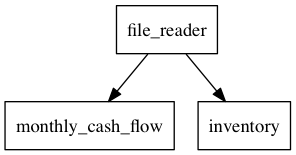

In [8]:
TransactionTup = namedtuple('TransactionTup', 'date event item quantity price')

def record_generator():
    with open('./transactions.csv') as f:
        for rec in DictReader(f):
            yield TransactionTup(**rec)
            

class FileReader(Node):
    def process(self, file_name):
        with open(file_name) as f:
            for rec in DictReader(f):
                rec['quantity'] = int(rec['quantity'])
                rec['price'] = float(rec['price'])
                self.push(TransactionTup(**rec))
                
class Aggregator(Node):
    def begin(self):
        self.aggregate = {}
    
    def get_key(self, rec):
        raise NotImplemented('define this method is subclass')
    
    def get_value(self, rec):
        raise NotImplemented('define this method is subclass')
    
    def process(self, rec):
        key = self.get_key(rec)
        self.aggregate[key] = self.aggregate.get(key, 0.) + self.get_value(rec)
        
    def end(self):
        self.global_state['{}_agg'.format(self.name)] =  self.aggregate
        

class Inventory(Aggregator):
    def get_key(self, rec):
        return rec.date[:7] + '_' + rec.item
    
    def get_value(self, rec):
        return rec.quantity if rec.event == 'purchase' else -rec.quantity
        
class MonthlyCashFlow(Aggregator):
    def get_key(self, rec):
        return rec.date[:7]
    
    def get_value(self, rec):
        return rec.price if rec.event == 'sale' else -rec.price
    
        
pipe = Pipeline(
    FileReader('file_reader') | 
        [Inventory('inventory'), MonthlyCashFlow('monthly_cash_flow')]
        
)

def event_router(item):
    return '{}_processor'.format(item.event)

    
pipe.consume(['./transactions.csv'])
pipe.plot(display_noteook=True)
            


In [9]:
pipe.global_state.inventory_agg

{'2014-12_hammer': 20.0,
 '2014-12_paint': 13.0,
 '2014-12_saw': 10.0,
 '2014-12_screws': 100.0,
 '2014-12_tractor': 1.0,
 '2014-12_trailer': 1.0,
 '2014-12_wheelbarrow': 2.0,
 '2015-01_hammer': -12.0,
 '2015-01_paint': -8.0,
 '2015-01_saw': -7.0,
 '2015-01_screws': -68.0,
 '2015-01_tractor': -1.0,
 '2015-01_trailer': 1.0,
 '2015-01_wheelbarrow': 0.0,
 '2015-02_hammer': 9.0,
 '2015-02_paint': 8.0,
 '2015-02_saw': 2.0,
 '2015-02_screws': 81.0,
 '2015-02_tractor': 0.0,
 '2015-02_trailer': -1.0,
 '2015-02_wheelbarrow': -2.0,
 '2015-03_hammer': 4.0,
 '2015-03_paint': -7.0,
 '2015-03_saw': -2.0,
 '2015-03_screws': -75.0,
 '2015-03_tractor': 1.0,
 '2015-03_trailer': 1.0,
 '2015-03_wheelbarrow': 1.0,
 '2015-04_hammer': -9.0,
 '2015-04_paint': 9.0,
 '2015-04_saw': 4.0,
 '2015-04_screws': 75.0,
 '2015-04_tractor': 0.0,
 '2015-04_trailer': 0.0,
 '2015-04_wheelbarrow': 1.0,
 '2015-05_hammer': 1.0,
 '2015-05_paint': -3.0,
 '2015-05_saw': -4.0,
 '2015-05_screws': 38.0,
 '2015-05_tractor': 0.0,
 '20

In [ ]:
['hammer', 'paint', 'saw', 'screws', 'tractor', 'trailer', 'wheelbarrow']